In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as ntx
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import CrossEntropyLoss

In [2]:
np.random.seed(0)
tf.random.set_seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [3]:
df = pd.read_csv('abalone_benchmark_0901.csv')

In [4]:
df

,point.id,motherset,origin,original.label,diff.score,ground.truth,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1069,abalone,regression,6,0.328105,nominal,-1.282275,-1.288608,-0.944757,-1.239306,-1.094180,-1.405781,-1.259537
1,abalone_point_4174,abalone,regression,10,0.345707,anomaly,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666
2,abalone_point_1265,abalone,regression,8,0.583887,nominal,-0.574489,-0.784778,-0.944757,-0.931387,-0.006161,-0.940513,-0.925491
3,abalone_point_3784,abalone,regression,12,0.123745,anomaly,0.799447,0.726711,0.967881,0.615344,0.761985,0.774593,0.482528
4,abalone_point_0404,abalone,regression,10,0.429648,anomaly,-0.074876,0.071733,0.011562,-0.275785,-0.215655,-0.260857,-0.278952
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1901,abalone_point_3975,abalone,regression,8,0.177021,nominal,-0.865930,-0.885544,-0.586137,-0.855937,-0.693212,-0.794546,-0.961410
1902,abalone_point_3027,abalone,regression,8,0.154020,nominal,-0.241414,-0.331331,-0.586137,-0.656096,-0.533276,-0.707879,-0.638140
1903,abalone_point_3090,abalone,regression,8,0.188002,nominal,-0.574489,-0.583246,-0.705677,-0.756016,-0.717991,-0.634896,-0.778224
1904,abalone_point_1127,abalone,regression,9,0.282812,nominal,0.299834,0.222882,0.131102,0.144289,0.471396,-0.028223,-0.034704


**Data Preparation**

In [6]:
df = df.drop(columns = ['motherset', 'origin', 'original.label', 'diff.score'])
df

,point.id,ground.truth,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1069,nominal,-1.282275,-1.288608,-0.944757,-1.239306,-1.094180,-1.405781,-1.259537
1,abalone_point_4174,anomaly,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666
2,abalone_point_1265,nominal,-0.574489,-0.784778,-0.944757,-0.931387,-0.006161,-0.940513,-0.925491
3,abalone_point_3784,anomaly,0.799447,0.726711,0.967881,0.615344,0.761985,0.774593,0.482528
4,abalone_point_0404,anomaly,-0.074876,0.071733,0.011562,-0.275785,-0.215655,-0.260857,-0.278952
...,...,...,...,...,...,...,...,...,...
1901,abalone_point_3975,nominal,-0.865930,-0.885544,-0.586137,-0.855937,-0.693212,-0.794546,-0.961410
1902,abalone_point_3027,nominal,-0.241414,-0.331331,-0.586137,-0.656096,-0.533276,-0.707879,-0.638140
1903,abalone_point_3090,nominal,-0.574489,-0.583246,-0.705677,-0.756016,-0.717991,-0.634896,-0.778224
1904,abalone_point_1127,nominal,0.299834,0.222882,0.131102,0.144289,0.471396,-0.028223,-0.034704


In [7]:
df = df.rename(columns = {'ground.truth': 'target', 'point.id': 'point_id'})
df

,point_id,target,V1,V2,V3,V4,V5,V6,V7
0,abalone_point_1069,nominal,-1.282275,-1.288608,-0.944757,-1.239306,-1.094180,-1.405781,-1.259537
1,abalone_point_4174,anomaly,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666
2,abalone_point_1265,nominal,-0.574489,-0.784778,-0.944757,-0.931387,-0.006161,-0.940513,-0.925491
3,abalone_point_3784,anomaly,0.799447,0.726711,0.967881,0.615344,0.761985,0.774593,0.482528
4,abalone_point_0404,anomaly,-0.074876,0.071733,0.011562,-0.275785,-0.215655,-0.260857,-0.278952
...,...,...,...,...,...,...,...,...,...
1901,abalone_point_3975,nominal,-0.865930,-0.885544,-0.586137,-0.855937,-0.693212,-0.794546,-0.961410
1902,abalone_point_3027,nominal,-0.241414,-0.331331,-0.586137,-0.656096,-0.533276,-0.707879,-0.638140
1903,abalone_point_3090,nominal,-0.574489,-0.583246,-0.705677,-0.756016,-0.717991,-0.634896,-0.778224
1904,abalone_point_1127,nominal,0.299834,0.222882,0.131102,0.144289,0.471396,-0.028223,-0.034704


In [8]:
df['point_id'] = df['point_id'].str.replace('abalone_point_', '', regex = False).astype(int)
df

,point_id,target,V1,V2,V3,V4,V5,V6,V7
0,1069,nominal,-1.282275,-1.288608,-0.944757,-1.239306,-1.094180,-1.405781,-1.259537
1,4174,anomaly,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666
2,1265,nominal,-0.574489,-0.784778,-0.944757,-0.931387,-0.006161,-0.940513,-0.925491
3,3784,anomaly,0.799447,0.726711,0.967881,0.615344,0.761985,0.774593,0.482528
4,404,anomaly,-0.074876,0.071733,0.011562,-0.275785,-0.215655,-0.260857,-0.278952
...,...,...,...,...,...,...,...,...,...
1901,3975,nominal,-0.865930,-0.885544,-0.586137,-0.855937,-0.693212,-0.794546,-0.961410
1902,3027,nominal,-0.241414,-0.331331,-0.586137,-0.656096,-0.533276,-0.707879,-0.638140
1903,3090,nominal,-0.574489,-0.583246,-0.705677,-0.756016,-0.717991,-0.634896,-0.778224
1904,1127,nominal,0.299834,0.222882,0.131102,0.144289,0.471396,-0.028223,-0.034704


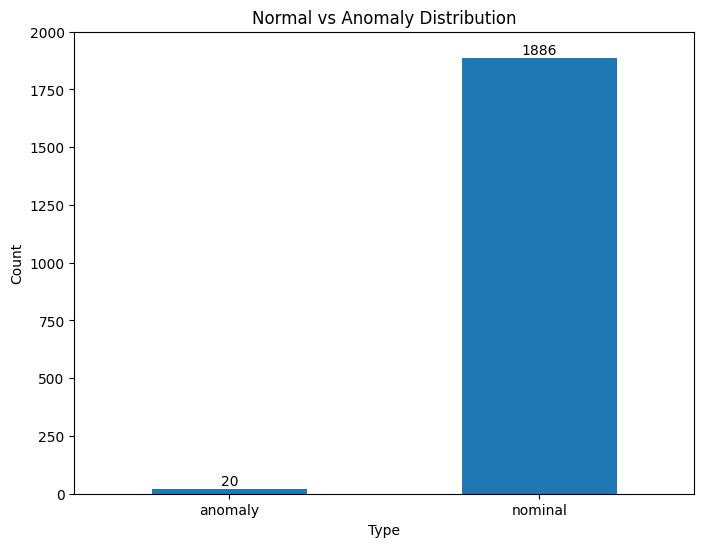

In [9]:
fig, ax = plt.subplots(figsize  = (8, 6))
counts = df.groupby('target').target.count()
counts.plot.bar(ax = ax, ylim = (0, counts.max() + 10))

for patch, count in zip(ax.patches, counts.values):
    height = patch.get_height()
    fig.axes[0].text(patch.get_x() + patch.get_width()/2, height + 5, str(count), ha ='center', va = 'bottom', size = 10)

plt.title('Normal vs Anomaly Distribution')
plt.xlabel('Type')
plt.xticks(rotation = 0)
plt.yticks(np.arange(0, 2100, step = 250))
plt.ylabel('Count')
plt.savefig('1.png')
plt.show()

In [10]:
df_sorted = df.sort_values(by = 'point_id', ascending = True)
df_sorted

,point_id,target,V1,V2,V3,V4,V5,V6,V7
1390,2,nominal,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842
169,3,nominal,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114
222,5,nominal,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599
488,6,nominal,-0.824296,-1.087076,-1.064297,-0.973191,-0.983802,-0.940513,-0.853654
1875,9,nominal,-0.407952,-0.381714,-0.347058,-0.650998,-0.643655,-0.621211,-0.530384
...,...,...,...,...,...,...,...,...,...
1323,4168,nominal,-0.199779,-0.280948,-0.347058,-0.513352,-0.407129,-0.493491,-0.612997
766,4169,nominal,-0.074876,-0.079416,-0.347058,-0.435862,-0.328287,-0.525421,-0.447771
1311,4172,nominal,0.299834,0.222882,0.370181,0.079035,0.183060,-0.078399,-0.070623
1,4174,anomaly,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666


In [11]:
df_sorted['target'] = df_sorted['target'].map({'nominal': 0, 'anomaly': 1})
df_sorted

,point_id,target,V1,V2,V3,V4,V5,V6,V7
1390,2,0,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842
169,3,0,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114
222,5,0,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599
488,6,0,-0.824296,-1.087076,-1.064297,-0.973191,-0.983802,-0.940513,-0.853654
1875,9,0,-0.407952,-0.381714,-0.347058,-0.650998,-0.643655,-0.621211,-0.530384
...,...,...,...,...,...,...,...,...,...
1323,4168,0,-0.199779,-0.280948,-0.347058,-0.513352,-0.407129,-0.493491,-0.612997
766,4169,0,-0.074876,-0.079416,-0.347058,-0.435862,-0.328287,-0.525421,-0.447771
1311,4172,0,0.299834,0.222882,0.370181,0.079035,0.183060,-0.078399,-0.070623
1,4174,1,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666


In [12]:
df_sorted = df_sorted.drop(columns = ['point_id'])
df_sorted

,target,V1,V2,V3,V4,V5,V6,V7
1390,0,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842
169,0,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114
222,0,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599
488,0,-0.824296,-1.087076,-1.064297,-0.973191,-0.983802,-0.940513,-0.853654
1875,0,-0.407952,-0.381714,-0.347058,-0.650998,-0.643655,-0.621211,-0.530384
...,...,...,...,...,...,...,...,...
1323,0,-0.199779,-0.280948,-0.347058,-0.513352,-0.407129,-0.493491,-0.612997
766,0,-0.074876,-0.079416,-0.347058,-0.435862,-0.328287,-0.525421,-0.447771
1311,0,0.299834,0.222882,0.370181,0.079035,0.183060,-0.078399,-0.070623
1,1,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666


In [13]:
df_x = df_sorted.iloc[:, 1:8]
df_y = df_sorted.iloc[:, 0:1]

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.3, random_state = 0)

In [15]:
smote = SMOTE(random_state = 0)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [16]:
y_train_resampled.mean()

target    0.5
dtype: float64

**Neural Network Model**

In [18]:
neural_network = models.Sequential([
    layers.InputLayer(shape = ([7])), 
    layers.Dense(28, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(14, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(2, activation='softmax')    
])
neural_network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 28)                  │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             406 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │              30 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 660 (2.58 KB)

 Trainable params: 660 (2.58 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
neural_network.compile(loss = 'sparse_categorical_crossentropy', 
                       optimizer = tf.keras.optimizers.Adam(0.001), 
                       metrics = ['accuracy'])

history_nn = neural_network.fit(x_train_resampled, y_train_resampled, epochs = 100)

Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5458 - loss: 0.6869
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6559 - loss: 0.5932
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6836 - loss: 0.5844
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7221 - loss: 0.5629
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7541 - loss: 0.5397
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7737 - loss: 0.5092
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7972 - loss: 0.4869
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8207 - loss: 0.4652
Epoch 9/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8226 - loss: 0.4378
Epoch 10/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8442 - loss: 0.4133
Epoch 11/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8492 - loss: 0.3954
Epoch 12/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy:

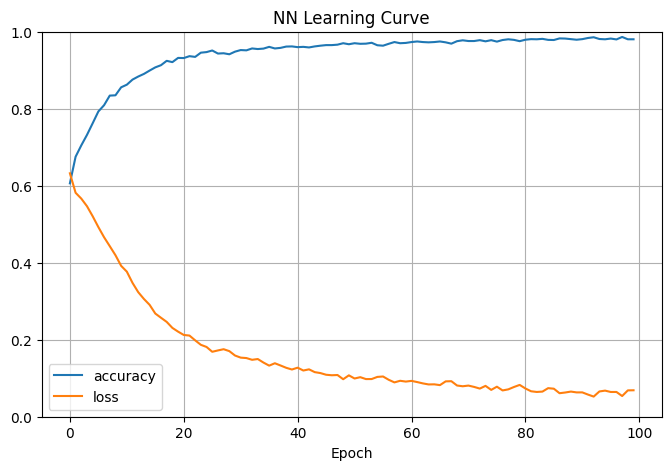

In [20]:
pd.DataFrame(history_nn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('NN Learning Curve')
plt.xlabel('Epoch')
plt.savefig('2.png')
plt.show()

In [21]:
nn_y_pred = neural_network.predict(x_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [22]:
nn_y_pred = np.argmax(nn_y_pred, axis = 1).reshape(-1, 1)

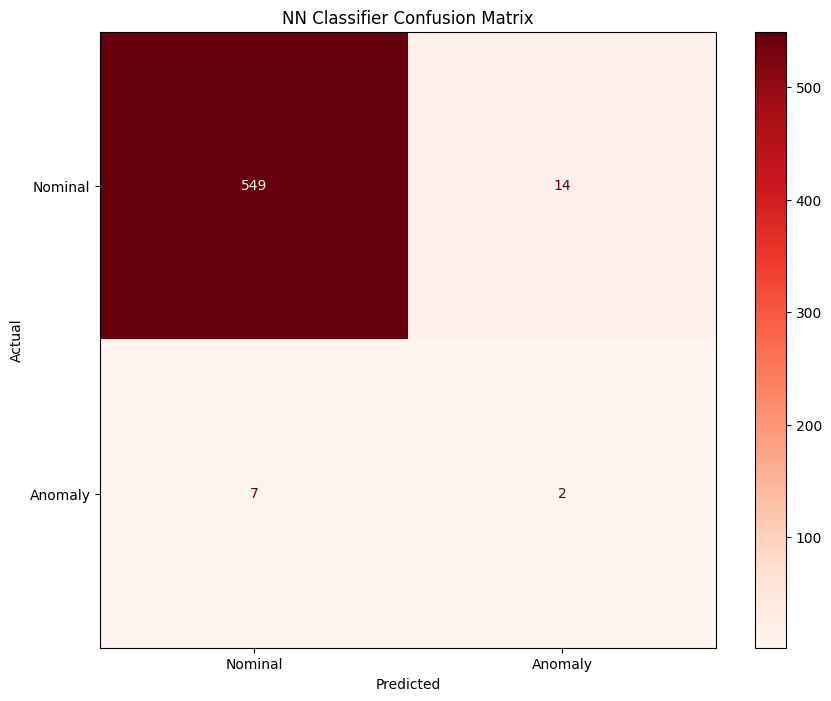

In [23]:
confusion_mat = confusion_matrix(y_test, nn_y_pred)
display_confusion_mat = ConfusionMatrixDisplay(confusion_mat, display_labels = ['Nominal', 'Anomaly'])
display_confusion_mat.plot(include_values = True, cmap = 'Reds', ax = plt.subplots(figsize = (10, 8))[1], values_format = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('NN Classifier Confusion Matrix')
plt.savefig('con_mat_nn_new.png')
plt.show()

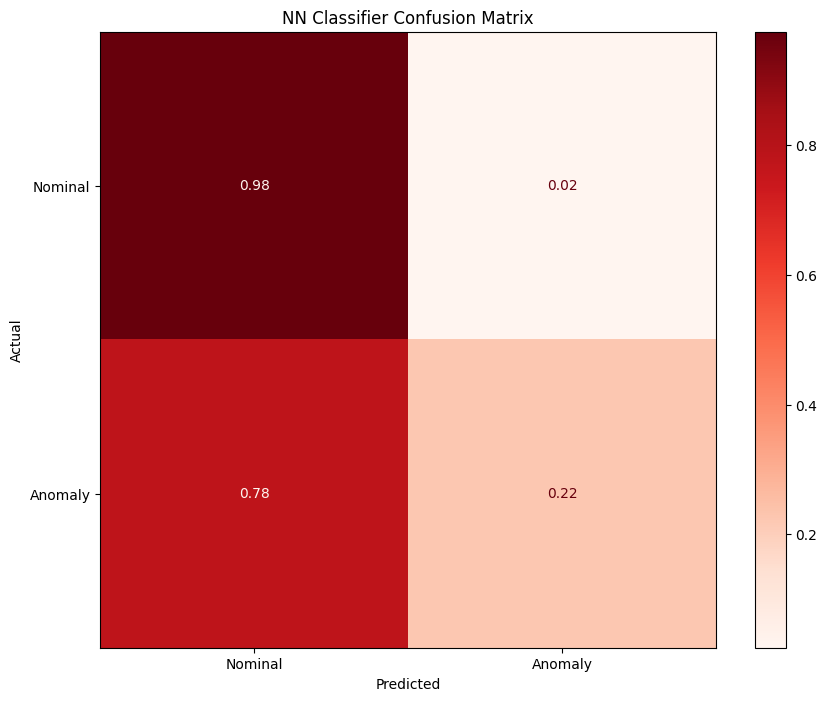

In [24]:
confusion_mat = confusion_matrix(y_test, nn_y_pred)
confusion_ratios = confusion_mat/confusion_mat.sum(axis = 1, keepdims = True)
display_confusion_mat = ConfusionMatrixDisplay(confusion_ratios, display_labels = ['Nominal', 'Anomaly'])
display_confusion_mat.plot(include_values = True, cmap = 'Reds', ax = plt.subplots(figsize = (10, 8))[1], values_format = '.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('NN Classifier Confusion Matrix')
plt.savefig('nn_con_mat_new.png')
plt.show()

In [25]:
print(metrics.classification_report(y_test, nn_y_pred, target_names = ['Nominal', 'Anomaly'], digits = 3, zero_division = True))

              precision    recall  f1-score   support

     Nominal      0.987     0.975     0.981       563
     Anomaly      0.125     0.222     0.160         9

    accuracy                          0.963       572
   macro avg      0.556     0.599     0.571       572
weighted avg      0.974     0.963     0.968       572



**Graph Convolution Neural Network**

In [27]:
df_sorted = df.sort_values(by = 'point_id', ascending = True)
df_sorted

,point_id,target,V1,V2,V3,V4,V5,V6,V7
1390,2,nominal,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842
169,3,nominal,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114
222,5,nominal,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599
488,6,nominal,-0.824296,-1.087076,-1.064297,-0.973191,-0.983802,-0.940513,-0.853654
1875,9,nominal,-0.407952,-0.381714,-0.347058,-0.650998,-0.643655,-0.621211,-0.530384
...,...,...,...,...,...,...,...,...,...
1323,4168,nominal,-0.199779,-0.280948,-0.347058,-0.513352,-0.407129,-0.493491,-0.612997
766,4169,nominal,-0.074876,-0.079416,-0.347058,-0.435862,-0.328287,-0.525421,-0.447771
1311,4172,nominal,0.299834,0.222882,0.370181,0.079035,0.183060,-0.078399,-0.070623
1,4174,anomaly,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666


In [28]:
df_sorted['target'] = df_sorted['target'].map({'nominal': 0, 'anomaly': 1})
df_sorted

,point_id,target,V1,V2,V3,V4,V5,V6,V7
1390,2,0,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842
169,3,0,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114
222,5,0,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599
488,6,0,-0.824296,-1.087076,-1.064297,-0.973191,-0.983802,-0.940513,-0.853654
1875,9,0,-0.407952,-0.381714,-0.347058,-0.650998,-0.643655,-0.621211,-0.530384
...,...,...,...,...,...,...,...,...,...
1323,4168,0,-0.199779,-0.280948,-0.347058,-0.513352,-0.407129,-0.493491,-0.612997
766,4169,0,-0.074876,-0.079416,-0.347058,-0.435862,-0.328287,-0.525421,-0.447771
1311,4172,0,0.299834,0.222882,0.370181,0.079035,0.183060,-0.078399,-0.070623
1,4174,1,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666


In [29]:
df_sorted = df_sorted.drop(columns = ['point_id'])
df_sorted

,target,V1,V2,V3,V4,V5,V6,V7
1390,0,-1.448812,-1.439757,-1.183837,-1.230130,-1.170770,-1.205077,-1.212842
169,0,0.050027,0.122116,-0.107978,-0.309432,-0.463444,-0.356647,-0.207114
222,0,-1.615350,-1.540523,-1.422916,-1.271933,-1.215822,-1.287183,-1.320599
488,0,-0.824296,-1.087076,-1.064297,-0.973191,-0.983802,-0.940513,-0.853654
1875,0,-0.407952,-0.381714,-0.347058,-0.650998,-0.643655,-0.621211,-0.530384
...,...,...,...,...,...,...,...,...
1323,0,-0.199779,-0.280948,-0.347058,-0.513352,-0.407129,-0.493491,-0.612997
766,0,-0.074876,-0.079416,-0.347058,-0.435862,-0.328287,-0.525421,-0.447771
1311,0,0.299834,0.222882,0.370181,0.079035,0.183060,-0.078399,-0.070623
1,1,0.549640,0.323648,-0.107978,0.279896,0.358765,0.309325,0.155666


In [30]:
df_x = df_sorted.iloc[:, 1:8]
df_y = df_sorted.iloc[:, 0:1]

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.3, random_state = 0)

In [32]:
smote = SMOTE(random_state = 0)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [33]:
x_train_tensor = torch.tensor(x_train_resampled.to_numpy(), dtype=torch.float)
x_train_tensor.shape

torch.Size([2646, 7])

In [34]:
edges_train_tensor = kneighbors_graph(x_train_resampled, n_neighbors = 10, mode = 'connectivity', include_self = True)
edge_index_train = torch.tensor(edges_train_tensor.nonzero(), dtype = torch.long)
edge_index_train.shape

C:\Users\md3\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
C:\Users\md3\AppData\Local\Temp\ipykernel_4732\2030828809.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_index_train = torch.tensor(edges_train_tensor.nonzero(), dtype = torch.long)


torch.Size([2, 26460])

In [35]:
y_train_tensor = torch.tensor(y_train_resampled.to_numpy().flatten(), dtype = torch.long)
y_train_tensor.shape

torch.Size([2646])

In [36]:
data_train = Data(x = x_train_tensor, edge_index = edge_index_train, y = y_train_tensor)
data_train

Data(x=[2646, 7], edge_index=[2, 26460], y=[2646])

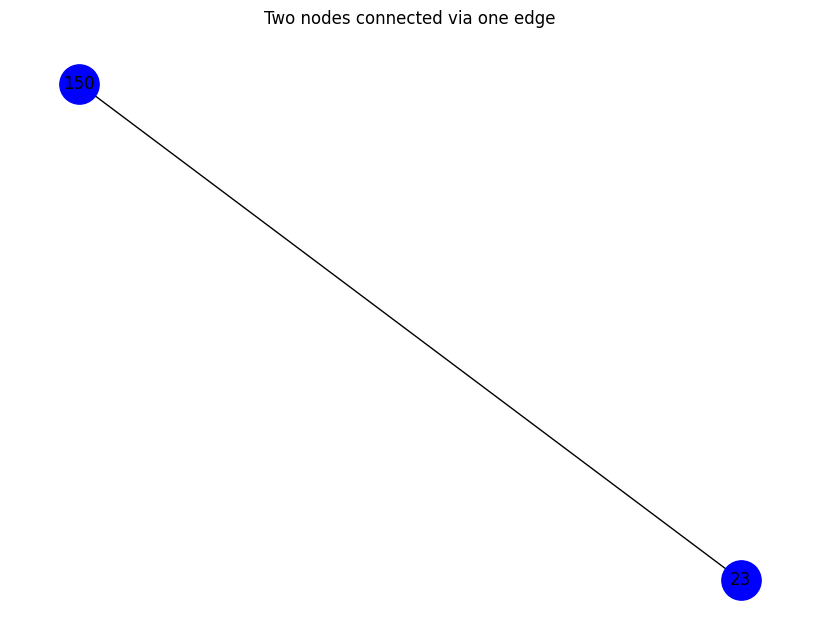

In [37]:
graph = ntx.Graph()
plt.figure(figsize = (8, 6))
graph.add_edge(150, 23)
ntx.draw(graph, with_labels = True, node_color = "blue", node_size = 800, edge_color = "black")
plt.title('Two nodes connected via one edge')
plt.savefig('11.png', bbox_inches = 'tight')
plt.show()

In [38]:
x_tensor = torch.tensor(df_x.to_numpy(), dtype=torch.float)
x_tensor.shape

torch.Size([1906, 7])

In [39]:
edges_tensor = kneighbors_graph(df_x, n_neighbors = 10, mode = 'connectivity', include_self = True)
edge_index = torch.tensor(edges_tensor.nonzero(), dtype = torch.long)
edge_index.shape

C:\Users\md3\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


torch.Size([2, 19060])

In [40]:
y_tensor = torch.tensor(df_y.to_numpy().flatten(), dtype=torch.long)
y_tensor.shape

torch.Size([1906])

In [41]:
data = Data(x = x_tensor, edge_index = edge_index, y = y_tensor)

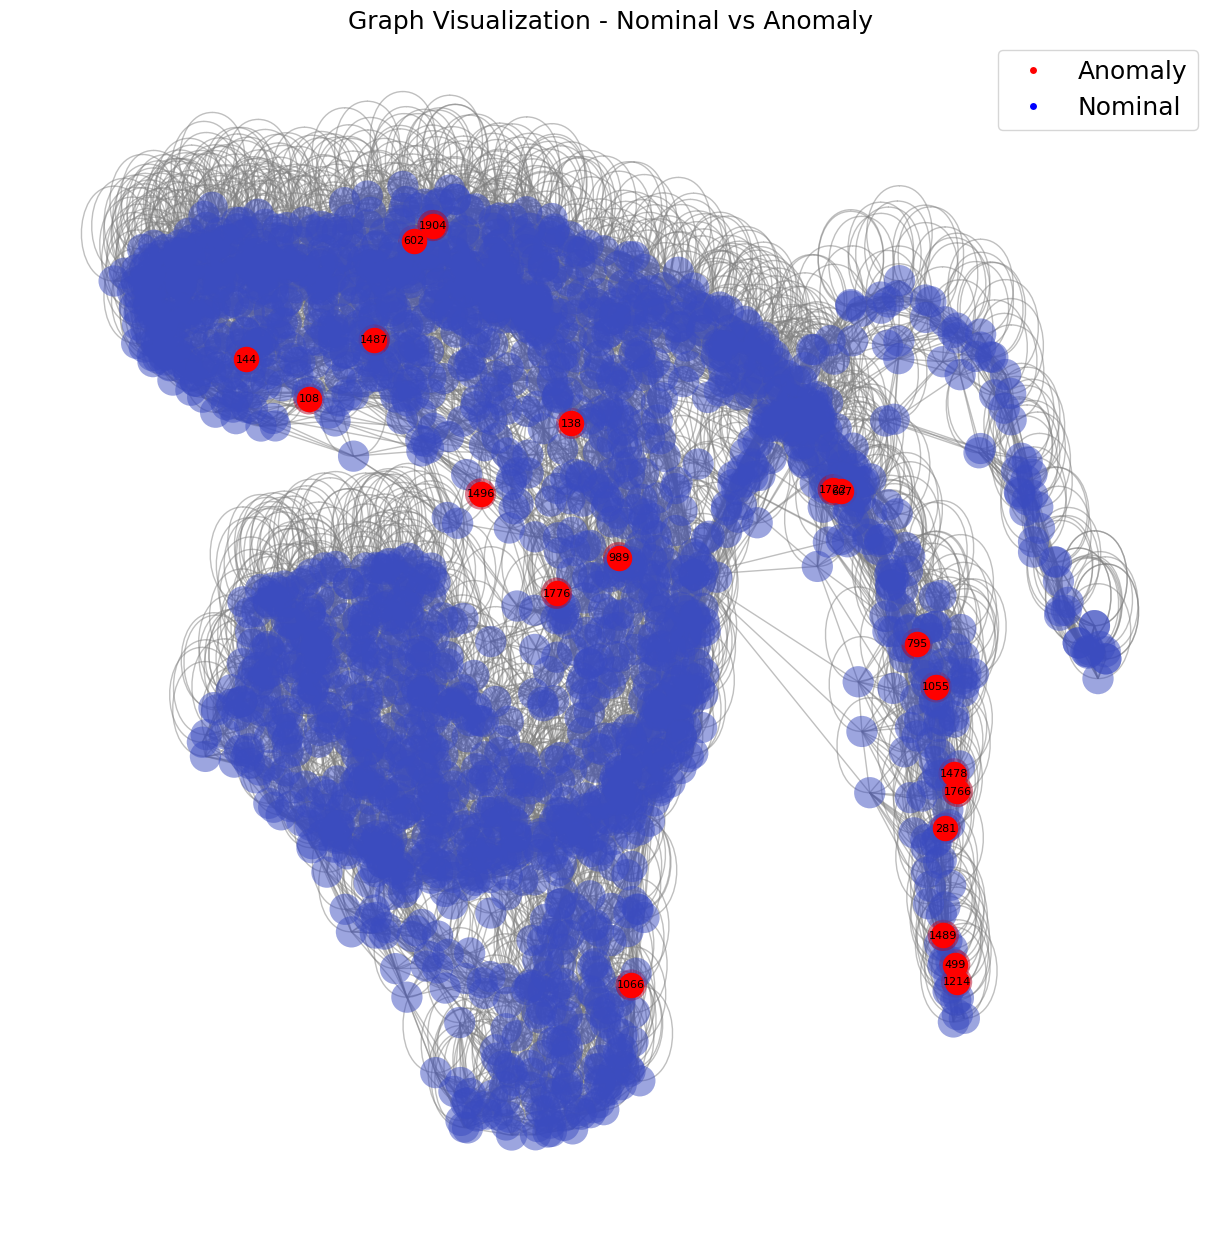

In [42]:
edges = data.edge_index.t().tolist()

graph = ntx.Graph()
graph.add_nodes_from(range(data.x.shape[0]))
graph.add_edges_from(edges)

node_colors = data.y.numpy()

plt.figure(figsize = (12, 12))

pos = ntx.spring_layout(graph, seed = 0)

ntx.draw(graph, pos, with_labels = False, node_size = 500, node_color = node_colors, cmap = 'coolwarm', edge_color = 'gray', 
         alpha = 0.5, linewidths = 0.1)

anomaly_nodes = [i for i, label in enumerate(node_colors) if label == 1]
ntx.draw_networkx_nodes(graph, pos, nodelist = anomaly_nodes, node_color = 'red', label = 'Anomalies')

ntx.draw_networkx_labels(graph, pos, labels = {i: str(i) for i in anomaly_nodes}, font_size = 8)

plt.title("Graph Visualization - Nominal vs Anomaly", fontsize = 18)
plt.legend(handles = [plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'red', label = 'Anomaly'),
                      plt.Line2D([0], [0], marker = 'o', color = 'w', markerfacecolor = 'blue', label = 'Nominal')], 
           loc = 'upper right', fontsize = 18)
plt.savefig('6.png', bbox_inches = 'tight')
plt.show()

In [43]:
x_test_tensor = torch.tensor(x_test.to_numpy(), dtype = torch.float)
x_test_tensor.shape

torch.Size([572, 7])

In [44]:
edges_test_tensor = kneighbors_graph(x_test, n_neighbors = 10, mode = 'connectivity', include_self = True)
edge_index_test = torch.tensor(edges_test_tensor.nonzero(), dtype = torch.long)
edge_index_test.shape

C:\Users\md3\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


torch.Size([2, 5720])

In [45]:
y_test_tensor = torch.tensor(y_test.to_numpy().flatten(), dtype=torch.long)
y_test_tensor.shape

torch.Size([572])

In [46]:
data_test = Data(x = x_test_tensor, edge_index = edge_index_test, y = y_test_tensor)
data_test

Data(x=[572, 7], edge_index=[2, 5720], y=[572])

In [47]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16) 
        self.conv2 = GCNConv(16, out_channels) 

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index) 
        return F.log_softmax(x, dim = 1)

In [48]:
model = GCN(in_channels = data_train.x.shape[1], out_channels = 2) 

optimizer = optim.Adam(model.parameters(), lr = 0.002)
criterion = CrossEntropyLoss()

In [49]:
def train(model, data, optimizer, criterion, epochs = 500):
    history = {'val_accuracy': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(data)

        train_loss = criterion(out[data.train_mask], data.y[data.train_mask]) if hasattr(data, 'train_mask') else criterion(out, data.y)

        _, pred = out.max(dim = 1)  

        correct = (pred == data.y).sum().item()
        accuracy = correct / data.num_nodes
        history['val_accuracy'].append(accuracy)

        train_loss.backward()  
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out, data_train.y)
            history['val_loss'].append(val_loss.item())
        

        print(f"Epoch {epoch+1}/{epochs}, Loss: {val_loss.item():.4f}, Accuracy: {accuracy:.4f}")
    return history

history_gcn = train(model, data_train, optimizer, criterion, epochs = 1000)

Epoch 1/1000, Loss: 0.6678, Accuracy: 0.6417
Epoch 2/1000, Loss: 0.6609, Accuracy: 0.6421
Epoch 3/1000, Loss: 0.6543, Accuracy: 0.6421
Epoch 4/1000, Loss: 0.6481, Accuracy: 0.6421
Epoch 5/1000, Loss: 0.6422, Accuracy: 0.6432
Epoch 6/1000, Loss: 0.6366, Accuracy: 0.6406
Epoch 7/1000, Loss: 0.6314, Accuracy: 0.6398
Epoch 8/1000, Loss: 0.6264, Accuracy: 0.6391
Epoch 9/1000, Loss: 0.6217, Accuracy: 0.6387
Epoch 10/1000, Loss: 0.6172, Accuracy: 0.6391
Epoch 11/1000, Loss: 0.6129, Accuracy: 0.6395
Epoch 12/1000, Loss: 0.6089, Accuracy: 0.6398
Epoch 13/1000, Loss: 0.6050, Accuracy: 0.6398
Epoch 14/1000, Loss: 0.6014, Accuracy: 0.6402
Epoch 15/1000, Loss: 0.5979, Accuracy: 0.6406
Epoch 16/1000, Loss: 0.5946, Accuracy: 0.6417
Epoch 17/1000, Loss: 0.5915, Accuracy: 0.6425
Epoch 18/1000, Loss: 0.5886, Accuracy: 0.6429
Epoch 19/1000, Loss: 0.5858, Accuracy: 0.6436
Epoch 20/1000, Loss: 0.5832, Accuracy: 0.6440
Epoch 21/1000, Loss: 0.5808, Accuracy: 0.6451
Epoch 22/1000, Loss: 0.5786, Accuracy: 0.64

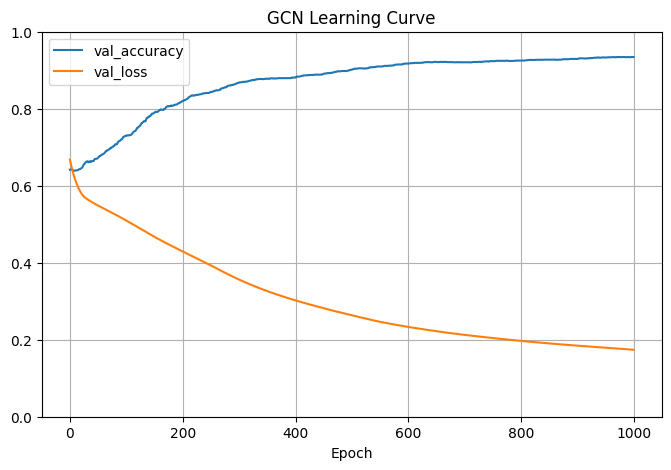

In [50]:
pd.DataFrame(history_gcn).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('6.png')
plt.title('GCN Learning Curve')
plt.xlabel('Epoch')
plt.savefig('7.png')
plt.show()

In [51]:
model.eval()
out = model(data_test)

_, gcn_y_pred = out.max(dim = 1)

y_test = data_test.y

gcn_y_pred = gcn_y_pred.cpu().numpy()
y_test = y_test.cpu().numpy()

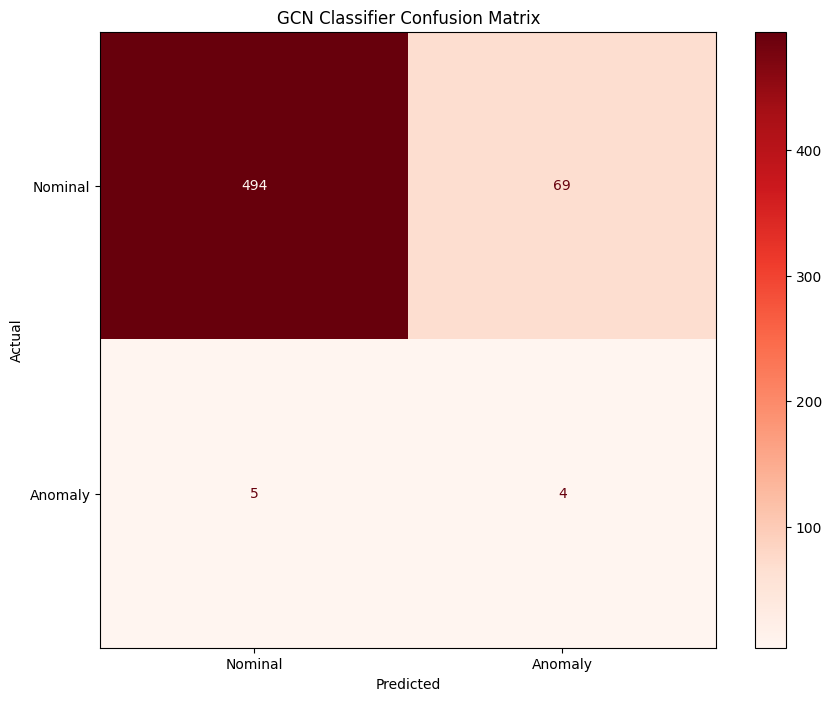

In [52]:
confusion_mat = confusion_matrix(y_test, gcn_y_pred)
display_confusion_mat = ConfusionMatrixDisplay(confusion_mat, display_labels = ['Nominal', 'Anomaly'])
display_confusion_mat.plot(include_values = True, cmap = 'Reds', ax = plt.subplots(figsize = (10, 8))[1], values_format = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('GCN Classifier Confusion Matrix')
plt.savefig('8.png')
plt.show()

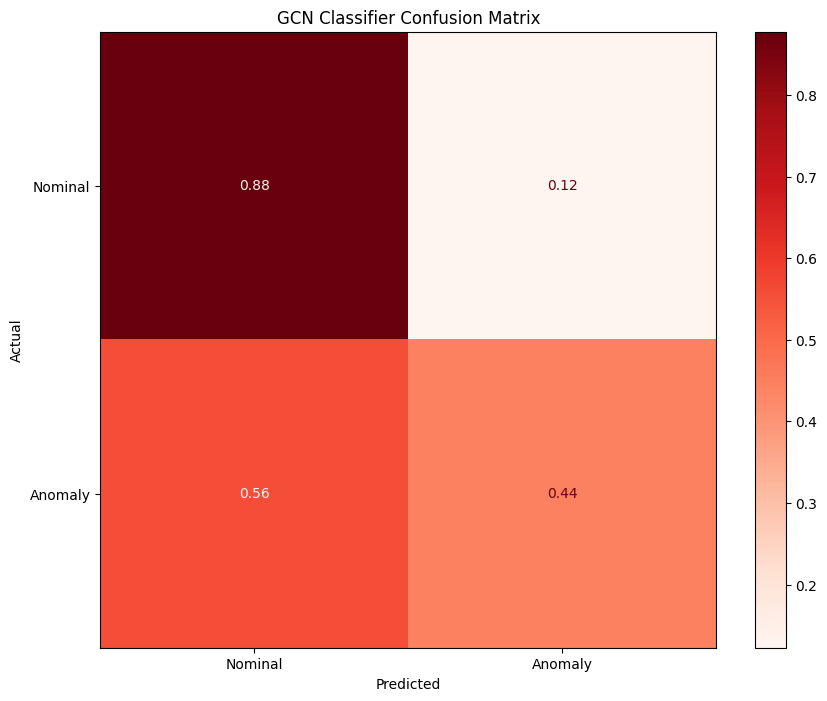

In [53]:
confusion_mat = confusion_matrix(y_test, gcn_y_pred)
confusion_ratios = confusion_mat/confusion_mat.sum(axis = 1, keepdims = True)
display_confusion_mat = ConfusionMatrixDisplay(confusion_ratios, display_labels = ['Nominal', 'Anomaly'])
display_confusion_mat.plot(include_values = True, cmap = 'Reds', ax = plt.subplots(figsize = (10, 8))[1], values_format = '.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('GCN Classifier Confusion Matrix')
plt.savefig('9.png')
plt.show()

In [54]:
print(metrics.classification_report(y_test, gcn_y_pred, target_names = ['Nominal', 'Anomaly'], digits = 3))

              precision    recall  f1-score   support

     Nominal      0.990     0.877     0.930       563
     Anomaly      0.055     0.444     0.098         9

    accuracy                          0.871       572
   macro avg      0.522     0.661     0.514       572
weighted avg      0.975     0.871     0.917       572

